In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

import xarray as xr
import intake

import config
import regrid_tools
import util

In [3]:
cat = intake.open_catalog("catalogs/fluxes-catalog-web.yml")
print(cat.yaml())

sources:
  fluxes-catalog-web:
    args:
      path: catalogs/fluxes-catalog-web.yml
    description: Flux datasets
    driver: intake.catalog.local.YAMLFileCatalog
    metadata: {}



In [4]:
version = "v2021"
yr1, yr2 = 1984, 2020

In [5]:
ds = cat[f"fgco2_MPI_SOM_FFN_{version}"].to_dask().compute()            
ds

<xarray.Dataset>
Dimensions:         (time: 468, lat: 180, lon: 360, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2020-12-15
  * lat             (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: bnds
Data variables:
    dco2            (time, lat, lon) float32 nan nan nan ... -33.13 -33.14
    atm_co2         (time, lat, lon) float32 nan nan nan ... 420.1 420.1 420.1
    sol             (time, lat, lon) float32 nan nan nan ... 7.063e-05 7.063e-05
    seaice          (time, lat, lon) float32 nan nan nan nan ... 0.97 0.97 0.97
    kw              (time, lat, lon) float32 nan nan nan ... 488.8 490.8 490.8
    spco2_raw       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spco2_smoothed  (time, lat, lon) float32 nan nan nan ... 385.2 385.2 385.2
    fgco2_raw       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    fgco2_smoothed  (time, lat, lon) float32 nan nan nan ... -0.03445 -0.03446
    time_bnds       (time, bnds) datetime64[ns] 1981-12-31 ... 2020-12-31
    lat_bnds        (lat, bnds) float32 -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
    lon_bnds        (lon, bnds) float32 -180.0 -179.0 -179.0 ... 179.0 180.0
Attributes:
    institution:    Max Planck Institute for Meteorology, Hamburg, Germany
    institude_id:   MPI-M
    model_id:       SOM-FFN
    run_id:         SOM_FFN_v2021
    contact:        Peter Landschutzer (peter.landschuetzer@mpimet.mpg.de)
    creation_date:  2021-11-16

In [6]:
ds.fgco2_smoothed

<xarray.DataArray 'fgco2_smoothed' (time: 468, lat: 180, lon: 360)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-0.09702573, -0.12921248, -0.09681816, ..., -0.09656385,
         -0.096691  , -0.12918012],
        [-0.07834408, -0.07839964, -0.07823385, ..., -0.05183164,
         -0.07819594, -0.07826956]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-0.05093985, -0.05086197, -0.05080707, ..., -0.03386183,
         -0.05082717, -0.05089206],
        [-0.03450203, -0.02301046, -0.02295201, ..., -0.03429219,
         -0.0344496 , -0.03446464]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2020-12-15
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:      CO2 flux smoothed
    standard_name:  CO2 flux smoothed
    units:          mol/m2/yr

In [7]:
time, time_bnds = util.gen_midmonth_cftime_coord((yr1, yr2)) #, climatology_year_end=yr2)

In [8]:
ds_mon = ds.sel(time=slice(f'{yr1}', f'{yr2}'))
ds_mon = ds_mon[["fgco2_smoothed"]].rename({"fgco2_smoothed": "SFCO2_OCN"})

ds_mon["area"] = util.compute_grid_area(ds_mon)
ds_mon["time"] = time
ds_mon[time.bounds]= time_bnds
ds_mon

<xarray.Dataset>
Dimensions:    (time: 444, lat: 180, lon: 360, d2: 2)
Coordinates:
  * time       (time) object 1984-01-16 12:00:00 ... 2020-12-16 12:00:00
  * lat        (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: d2
Data variables:
    SFCO2_OCN  (time, lat, lon) float32 nan nan nan ... -0.03445 -0.03446
    area       (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08
    time_bnds  (time, d2) object 1984-01-01 00:00:00 ... 2021-01-01 00:00:00
Attributes:
    institution:    Max Planck Institute for Meteorology, Hamburg, Germany
    institude_id:   MPI-M
    model_id:       SOM-FFN
    run_id:         SOM_FFN_v2021
    contact:        Peter Landschutzer (peter.landschuetzer@mpimet.mpg.de)
    creation_date:  2021-11-16

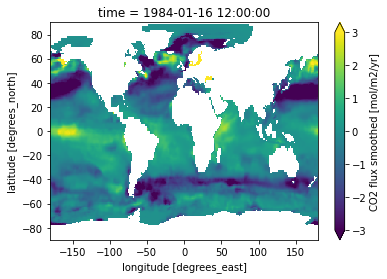

In [9]:
ds_mon.SFCO2_OCN.isel(time=0).plot(vmin=-3, vmax=3)

In [10]:
peryr_to_pers = 1. / 365. / 86400.

dso_grid = util.generate_latlon_grid(**config.config_dict["flux-dst-grid-kwargs"])[["area"]]

dso = ds_mon.copy()
dso['lat'] = dso_grid.lat
dso['lon'] = dso_grid.lon
dso['area'] = dso_grid.area

with xr.set_options(keep_attrs=True):
    dso['SFCO2_OCN'] = dso.SFCO2_OCN * peryr_to_pers    
dso.SFCO2_OCN.attrs['units'] = 'mol/m^2/s'
del dso.SFCO2_OCN.attrs['standard_name']

dso.attrs = {}
dso

<xarray.Dataset>
Dimensions:    (time: 444, lat: 180, lon: 360, d2: 2)
Coordinates:
  * time       (time) object 1984-01-16 12:00:00 ... 2020-12-16 12:00:00
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: d2
Data variables:
    SFCO2_OCN  (time, lat, lon) float32 nan nan nan ... -1.092e-09 -1.093e-09
    area       (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08
    time_bnds  (time, d2) object 1984-01-01 00:00:00 ... 2021-01-01 00:00:00

In [11]:
file_out = f"{config.flux_product_dir}/SFCO2_OCN.MPI-SOM-FFN.{version}.{yr1}01-{yr2}12.nc"

dso.attrs['source'] = f'MPI-SOM-FFN.{version} CO2 fluxes'
util.to_netcdf_clean(dso, file_out)

------------------------------
Writing /glade/work/mclong/sno-analysis/flux-products/SFCO2_OCN.MPI-SOM-FFN.v2021.198401-202012.nc
netcdf SFCO2_OCN.MPI-SOM-FFN.v2021.198401-202012 {
dimensions:
	time = 444 ;
	lat = 180 ;
	lon = 360 ;
	d2 = 2 ;
variables:
	float SFCO2_OCN(time, lat, lon) ;
		SFCO2_OCN:_FillValue = 9.96921e+36f ;
		SFCO2_OCN:long_name = "CO2 flux smoothed" ;
		SFCO2_OCN:units = "mol/m^2/s" ;
	double time(time) ;
		time:shift_time = 0. ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1984-01-01" ;
		time:calendar = "gregorian" ;
	double lat(lat) ;
		lat:units = "degrees_north" ;
		lat:long_name = "Latitude" ;
	double lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "Longitude" ;
	float area(lat, lon) ;
		area:_FillValue = 9.96921e+36f ;
		area:units = "m^2" ;
		area:long_name = "area" ;
	double time_bnds(time, d2) ;

// global attributes:
		:source = "MPI-SOM-FFN.v2021 CO2 fluxes" ;
		:history = "created by https://github.com/matt-long/sno-analysis/tre

In [12]:
curator = util.curate_flux_products()
curator.add_source(
        key=f"SFCO2_OCN.MPI-SOM-FFN",
        urlpath=file_out,
        description=cat[f"fgco2_MPI_SOM_FFN_{version}"].description,
    )